In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import sys
sys.path.append('/home/nibdombe/deep_eit/')
from data_processing.obj2py import read_get
from utils.helper import make_cmap
import matplotlib.pyplot as plt
from fnmatch import fnmatch
from reconstruction.resist import reconstruct
from tqdm import tqdm
import imageio
import cv2

In [2]:
case_dir = '/home/nibdombe/deep_eit/data/raw/case_real/Ki_EIT_01'
files = os.listdir(case_dir)
files = [os.path.join(case_dir, f) for f in files if f.endswith('.get')]
cmap = make_cmap()

rec_number = 5
level = 1
cut_thres = 4

In [3]:
for file in files:
    if fnmatch(file, f'*{str(rec_number).zfill(3)}_SF_{level}*'):
        data = read_get(file)
        data = data.reshape(143,-1)[:,:208]
        print(file)

/home/nibdombe/deep_eit/data/raw/case_real/Ki_EIT_01/KI_EIT_01_019_SF_1_U_top_I_top.get


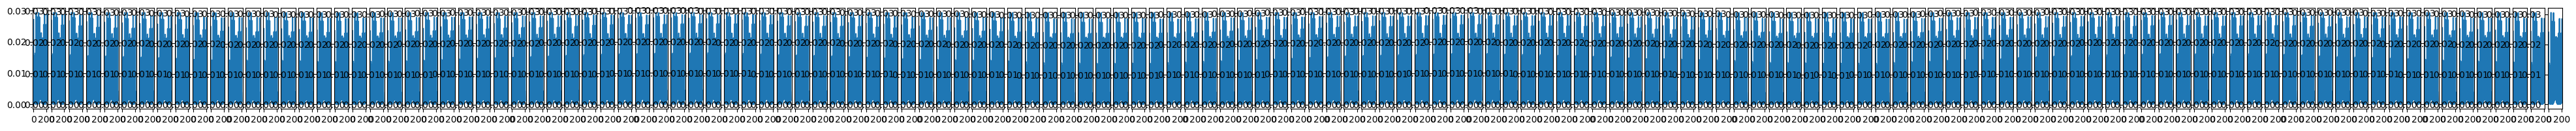

In [7]:
fig, axes = plt.subplots(1,data.shape[0],figsize=(50,2))
for n,d in enumerate(data):
    axes[n].plot(d)

In [8]:
min_idx = data.mean(axis=1).argmin()
max_idx = data.mean(axis=1).argmax()
print(min_idx, max_idx)

104 37


In [9]:
for level in [1,2,3]:
    for file in files:
        if fnmatch(file, f'*{str(rec_number).zfill(3)}_SF_{level}*'):
            data = read_get(file).reshape(143,-1)[:,:208]
            data_sort = data[data.mean(axis=1).argsort()]
            data_min = data_sort[:3].mean(axis=0)
            data_max = data_sort[-3:].mean(axis=0)
            np.save('/home/nibdombe/deep_eit/data/raw/case_real/Ki_EIT_01/expiration/level_'+str(level)+'.npy', data_min)
            np.save('/home/nibdombe/deep_eit/data/raw/case_real/Ki_EIT_01/inspiration/level_'+str(level)+'.npy', data_max)
            print(file)

/home/nibdombe/deep_eit/data/raw/case_real/Ki_EIT_01/KI_EIT_01_019_SF_1_U_top_I_top.get
/home/nibdombe/deep_eit/data/raw/case_real/Ki_EIT_01/KI_EIT_01_019_SF_2_U_mid_I_mid.get
/home/nibdombe/deep_eit/data/raw/case_real/Ki_EIT_01/KI_EIT_01_019_SF_3_U_bot_I_bot.get


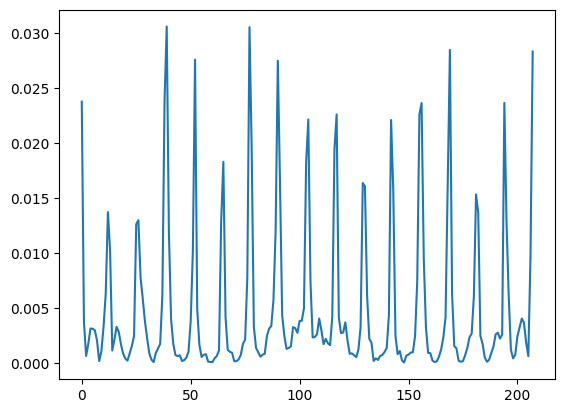

In [10]:
plt.plot(np.load('/home/nibdombe/deep_eit/data/raw/case_real/Ki_EIT_01/expiration/level_1.npy'))

# Use all frames

In [3]:
# parabula flights - 0g
case_dir = '/home/nibdombe/deep_eit/data/raw/case_real/Tag1'
# mri study
# case_dir = '/home/nibdombe/deep_eit/data/raw/case_real/Ki_EIT_01'
files = os.listdir(case_dir)
files = [os.path.join(case_dir, f) for f in files if (f.endswith('bot_372-459.get') or f.endswith('top_372-459.get') or f.endswith('mid_372-459.get'))]
# files = [os.path.join(case_dir, f) for f in files if f.endswith('.get')]
cmap = make_cmap()

signals = []
signals_levels = []
rec_number = 19

for file in files:
    for level in [1,2,3]:
        # if fnmatch(file, f'*{str(rec_number).zfill(3)}_SF_{level}*'):
        if fnmatch(file, f'*{str(rec_number).zfill(2)}_SF_{level}*'):
            print(file)
            signals.append(read_get(file).reshape(-1,256)[:,:208])
            signals_levels.append(level-1)
signals_levels = np.array(signals_levels).argsort()
data = np.array(signals)[signals_levels]
data = np.moveaxis(data,0,1)


/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_19_SF_2_U_mid_I_mid_372-459.get
/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_19_SF_3_U_bot_I_bot_372-459.get
/home/nibdombe/deep_eit/data/raw/case_real/Tag1/Tag_01_Msg_19_SF_1_U_top_I_top_372-459.get


In [35]:
data_level = data[:,0]
mean_data_level = np.mean(data_level, axis=1)
max = np.max(mean_data_level)
min = np.min(mean_data_level)
intervals = np.linspace(min, max, 4)
idx_low = np.where(mean_data_level<intervals[1])
idx_middle = np.where((mean_data_level>intervals[1]) & (mean_data_level<intervals[2]))
idx_high = np.where(mean_data_level>intervals[2])


In [54]:
breath = []
for d in mean_data_level:
    
    if d < intervals[1]:
        breath.append('Expiration')
    elif d > intervals[1] and d < intervals[2]:
        breath.append('Medium')
    else:
        breath.append('Inspiration')
breath = np.array(breath)

In [58]:
reconstruction = []

for d in tqdm(data):
    reconstruction.append(reconstruct(d, n_zpos=64, axis='coronal', verbose=False, device='cuda', resolution=128).squeeze())

100%|██████████| 88/88 [01:49<00:00,  1.25s/it]


In [59]:
reconstruction_all = np.moveaxis(np.array(reconstruction).squeeze(), 0, 1)
reconstruction_level = reconstruction_all[0]
norm = plt.Normalize(vmin=0, vmax=0.7)
rgb_image = cmap(norm(reconstruction_level))

In [60]:
breath

array(['Inspiration', 'Inspiration', 'Inspiration', 'Medium', 'Medium',
       'Medium', 'Medium', 'Expiration', 'Expiration', 'Expiration',
       'Expiration', 'Expiration', 'Expiration', 'Expiration',
       'Expiration', 'Expiration', 'Medium', 'Medium', 'Medium', 'Medium',
       'Inspiration', 'Inspiration', 'Inspiration', 'Inspiration',
       'Medium', 'Medium', 'Medium', 'Expiration', 'Expiration',
       'Expiration', 'Expiration', 'Expiration', 'Expiration',
       'Expiration', 'Expiration', 'Expiration', 'Expiration',
       'Expiration', 'Expiration', 'Expiration', 'Medium', 'Medium',
       'Medium', 'Inspiration', 'Inspiration', 'Inspiration',
       'Inspiration', 'Medium', 'Medium', 'Medium', 'Medium',
       'Expiration', 'Expiration', 'Expiration', 'Expiration',
       'Expiration', 'Expiration', 'Expiration', 'Expiration',
       'Expiration', 'Expiration', 'Expiration', 'Expiration',
       'Expiration', 'Expiration', 'Medium', 'Medium', 'Medium', 'Medium',
      

In [61]:
rgb_images = np.array([cv2.putText(r, b, (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1, cv2.LINE_AA) for r,b in zip(rgb_image,breath)])

In [62]:
# save the sequence of frames as a GIF
imageio.mimsave('animation.gif', (rgb_images[:,:,:,:3]*255).astype(np.uint8), fps=6.6) 

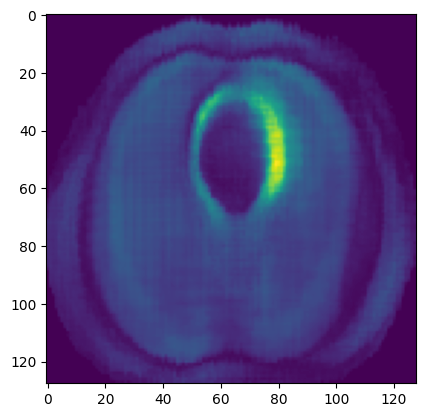

In [12]:
plt.imshow(reconstruction_level.std(axis=0))

In [13]:
data.shape

(88, 3, 208)

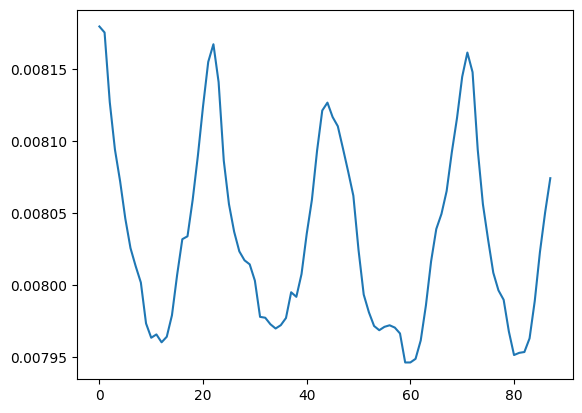

In [18]:
plt.plot(mean_data_level)

In [ ]:
data_dir = os.path.abspath('data/raw')
cases = os.listdir('data/raw')

# cases = [case for case in cases if (contains_substring(case, 'case_')) and os.path.isdir(os.path.join(data_dir, case))]
cases_signals = []

for case in cases:
    case_signals = []
    try:
        path = f'/home/nibdombe/deep_eit/data/raw/{case}'
        dir = os.listdir(os.path.join(path,'signals'))
        dir = [d for d in dir if d.endswith('.get')]
        if len(dir)>0:
            for d in dir:
                case_signals.append(read_get(os.path.join(path,'signals',d)))
        case_signals = np.array(case_signals) -  np.array(case_signals).mean(axis=0)
        cases_signals.append(case_signals)
    except Exception as e:
        print(e)
        

In [88]:
stds = []
for signals in cases_signals:
    try:
        stds.append(np.array(signals).std(axis=0))
    except Exception as e:
        print(e)

/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [89]:
stds = [std for std in stds if isinstance(std, np.ndarray)]

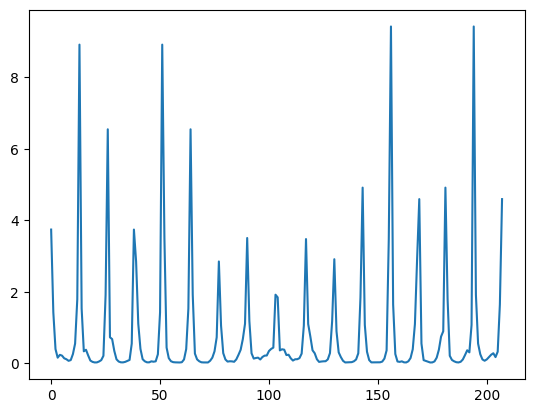

In [90]:
plt.plot(np.array(stds).mean(axis=0))

In [95]:
means = []
for signals in cases_signals:
    try:
        means.append(np.array(signals).mean(axis=0))
    except Exception as e:
        print(e)

/scratch/tmp/nibdombe/ipykernel_1836/2402337194.py:4: RuntimeWarning: Mean of empty slice.
  means.append(np.array(signals).mean(axis=0))
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


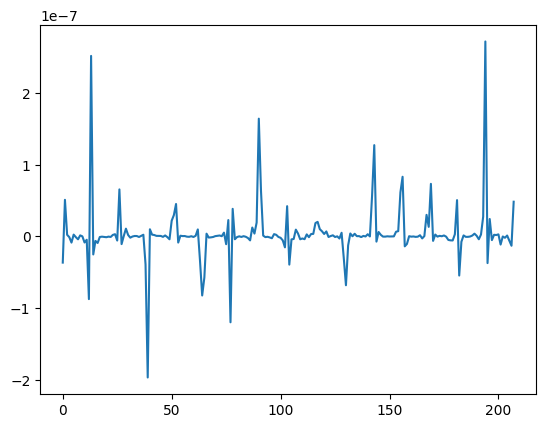

In [96]:
means = [mean for mean in means if isinstance(mean, np.ndarray)]
plt.plot(np.array(means).mean(axis=0))

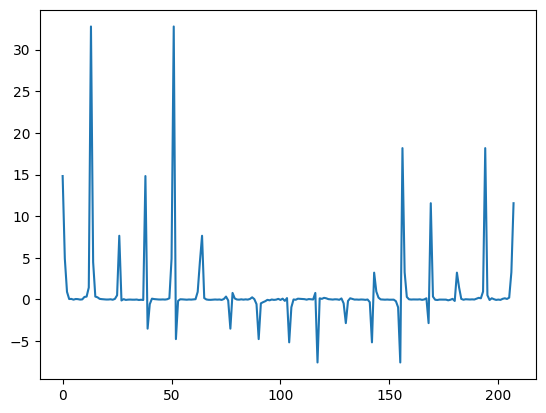

In [100]:
plt.plot(case_signals[0])

In [ ]:
for case in cases:
    case_signals = []
    try:
        path = f'/home/nibdombe/deep_eit/data/raw/{case}'
        dir = os.listdir(os.path.join(path,'signals'))
        dir = [d for d in dir if d.endswith('.get')]
        if len(dir)>0:
            for d in dir:
                case_signals.append(read_get(os.path.join(path,'signals',d)))
        case_signals = np.array(case_signals) -  np.array(case_signals).mean(axis=0)
        cases_signals.append(case_signals)
    break

In [ ]:
case_signals